Extracting EDF parameters from f:\WEBSITE\EDF_analysis\EDF+\Zacker\Zacker.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 139775  =      0.000 ...  1091.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwid

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Selecting by number: 5 components
Fitting ICA took 2.3s.


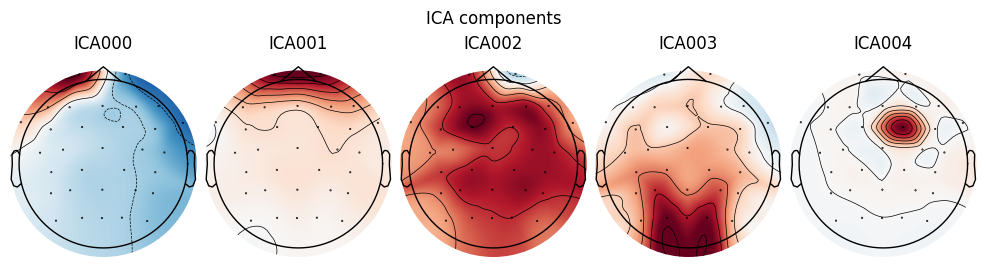

Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Using threshold: 0.44 for CTPS ECG detection
Using channel Fp1 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 1280 samples (10.000 s)

Number of ECG events detected : 1101 (average pulse 60 / min.)
Not setting metadata
1101 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 1101 events and 129 original time points ...
0 bad epochs dropped
App

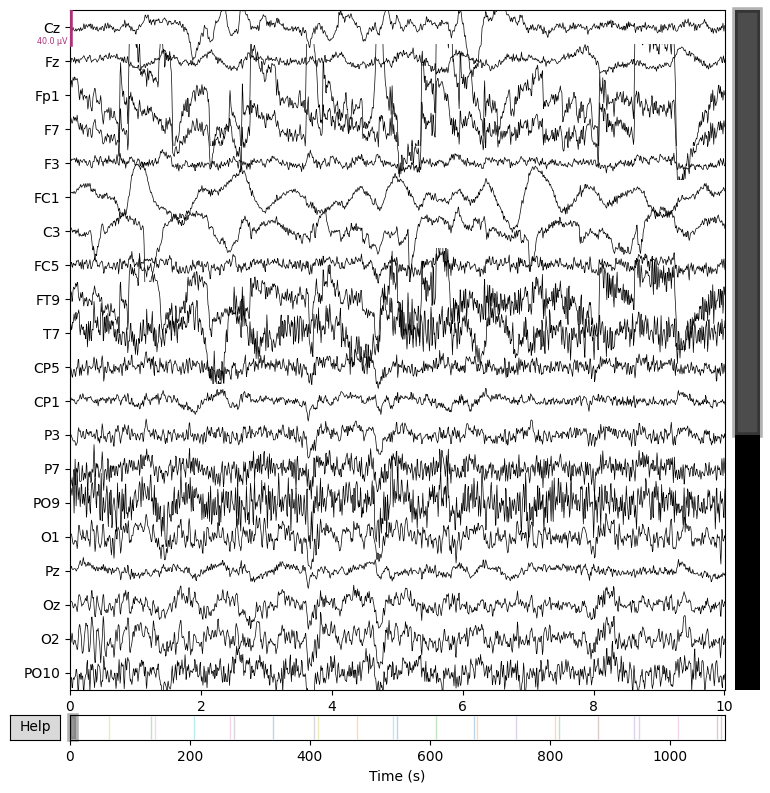

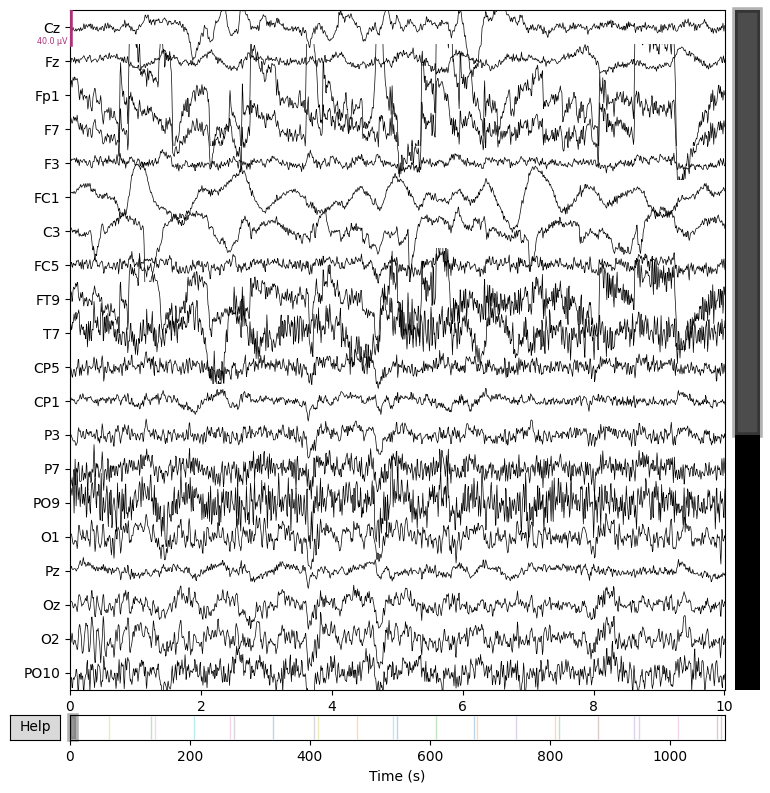

Finding segments below or above PTP threshold.
Completed the filtering step


In [2]:
# Let's try find_bads_ecg

# Let's try find_bads_ref
# Remaining methods to try:
# find_bads_ecg

import mne
from mne.preprocessing import ICA, EOGRegression
# from mne.preprocessing import EOGRegression
# Read your EDF file
raw = mne.io.read_raw_edf(r'..\EDF+\Zacker\Zacker.edf', preload=True, verbose=True, infer_types=True)
#raw = mne.io.read_raw_edf(r'e:\EEG\Archive\DATA2OTHERFORMATS\zachary_edf+.edf', preload=True, verbose=True, infer_types=True)
eeg_channels = ['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']

# Select only EEG channels
raw.pick_channels(eeg_channels)

# Set montage
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, on_missing='ignore')

# Apply preprocessing steps
raw.set_eeg_reference('average', projection=True)  # set EEG average reference
raw.filter(l_freq=1, h_freq=40)  # Apply band-pass filter MUST BE APPLIED BEFORE ICA!! SEE MNE DOCS mne.preprocessing.ICA.html

# Apply ICA to the raw EEG data to remove artifacts
# Set up ICA
ica = ICA(n_components=5, random_state=97, max_iter=800) #, max_iter=800 # removed to try auto

# Fit ICA on the raw EEG data
ica.fit(raw)

# Plot ICA components to manually inspect and identify components that capture eye blinks
ica.plot_components()

eogRegression = EOGRegression(picks_artifact='Fp1') # This was from their example, doesn't work without eog channel evidently eogRegression = EOGRegression(picks_artifact='eog')  picks='Fp1'
eogRegression.fit(raw) ### TODO: NOTE: do we use raw here, or do we piggy back off the previous data?

eogCorrected = eogRegression.apply(raw.copy())
# eogCorrected.plot()

# Use built-in methods to automatically find EOG-like components (since we don't have EOG data, we use EEG channels)
ecg_indices, ecg_scores = ica.find_bads_ecg(raw,ch_name='Fp1')  # We MUST put a channel here.  TODO: Find out which is best to put here
# ica.plot_scores(ecg_scores)

# Exclude the identified EOG-related components
ica.exclude = ecg_indices

# Apply the ICA solution to the raw data to remove the artifacts
raw_clean = ica.apply(raw.copy())

# Plot the raw and cleaned data for comparison using MNE's plotting functions
raw.plot(title='Raw EEG Data')
raw_clean.plot(title='Cleaned EEG Data')


mne.preprocessing.annotate_amplitude(raw, peak=0.0007, flat=1.0, bad_percent=5, min_duration=0.005, picks=eeg_channels, verbose=True)  #mne.preprocessing.annotate_amplitude(raw, peak=0.7, flat=0.3, bad_percent=5, min_duration=0.0000000000000000005, picks=eeg_channels, verbose=True)
print('Completed the filtering step')